# Manual temporal GNN using PyG

## Data generation code

In [ ]:
import torch
from torch_geometric.data import Data, Dataset

class PouchTemporalDataset(Dataset):
    def __init__(self, Ca, edge_index):
        """
        Ca: numpy array, shape (N, T)
        edge_index: torch.LongTensor, shape (2, E)
        """
        super().__init__()
        self.Ca = torch.tensor(Ca, dtype=torch.float)      # (N, T)
        self.edge_index = edge_index
        self.T = Ca.shape[1]

    def len(self):
        # One data point per (t -> t+1)
        return self.T - 1

    def get(self, idx):
        # x = Ca at time t
        x = self.Ca[:, idx].unsqueeze(1)      # (N, 1)
        # y = Ca at time t+1
        y = self.Ca[:, idx+1].unsqueeze(1)    # (N, 1)

        return Data(
            x=x,
            y=y,
            edge_index=self.edge_index
        )


In [ ]:
import torch
from torch_geometric.data import Data, Dataset


class SlidingWindowTemporalDataset(Dataset):
    """
    General-purpose sliding window dataset for temporal graph data.

    Parameters
    ----------
    Ca : array-like, shape (N, T)
        Node values over time. Can be numpy array or torch tensor.
        N = number of nodes, T = number of timepoints.
    edge_index : torch.LongTensor, shape (2, E)
        Graph connectivity (same for all timesteps).
    in_window : int, default=1
        Number of past timepoints to use as input (window size).
    horizon : int, default=1
        How many steps ahead of the LAST input frame to start predicting.
        Example: in_window=5, horizon=1:
            x uses t .. t+4, y starts at t+5.
    out_window : int, default=1
        Number of future timepoints to predict.
        out_window=1 → single-step target
        out_window>1 → sequence-to-sequence target.
    """

    def __init__(self, Ca, edge_index, in_window=1, horizon=1, out_window=1):
        super().__init__()

        # Ensure tensor, keep as float
        self.Ca = torch.as_tensor(Ca, dtype=torch.float)  # (N, T)
        self.edge_index = edge_index

        assert self.Ca.ndim == 2, "Ca must have shape (N, T)"
        self.N, self.T = self.Ca.shape

        self.in_window = int(in_window)
        self.horizon = int(horizon)
        self.out_window = int(out_window)

        assert self.in_window >= 1
        assert self.horizon >= 1
        assert self.out_window >= 1

        # How many samples can we make?
        # idx is the *start index* of the input window.
        #
        # Input uses       [idx, ..., idx + in_window - 1]
        # Last input idx = idx + in_window - 1
        # First target    = last_input + horizon
        #                = idx + in_window - 1 + horizon
        # Last target     = first_target + out_window - 1
        #                = idx + in_window - 1 + horizon + out_window - 1
        #
        # Require last_target <= T - 1
        # => idx <= T - (in_window + horizon + out_window) + 1
        self._max_start_idx = (
            self.T - (self.in_window + self.horizon + self.out_window) + 1
        )
        if self._max_start_idx <= 0:
            raise ValueError(
                f"Not enough timepoints T={self.T} for "
                f"in_window={self.in_window}, horizon={self.horizon}, out_window={self.out_window}"
            )

    def len(self):
        # Number of valid window starts
        return self._max_start_idx

    def get(self, idx):
        """
        idx: integer in [0, len(self)-1]
        Defines the *start* of the input window.
        """
        if idx < 0 or idx >= self.len():
            raise IndexError(f"Index {idx} out of range for dataset of length {self.len()}")

        # Input window: [idx, ..., idx + in_window - 1]
        x_start = idx
        x_end = idx + self.in_window  # slicing is exclusive, so this is +in_window

        # Target window:
        # first target index = last_input + horizon
        y_start = (idx + self.in_window - 1) + self.horizon
        y_end = y_start + self.out_window

        # Shapes:
        # x: (N, in_window)
        # y: (N, out_window)
        x = self.Ca[:, x_start:x_end]
        y = self.Ca[:, y_start:y_end]

        return Data(
            x=x,                 # (N, in_window)
            y=y,                 # (N, out_window)
            edge_index=self.edge_index
        )



## GraphSAGE -> GRU -> Linear Model

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class SAGE_GRU_Autoregressive(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32):
        super().__init__()

        # Spatial aggregator (GraphSAGE)
        self.sage = SAGEConv(in_channels, hidden_channels)

        # Temporal recurrence per node
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=False) # batch_first=False for (seq, batch, feature)

        # Decoder back to Ca(t+1)
        self.lin = nn.Linear(hidden_channels, 1)

        self.hidden_channels = hidden_channels

    def forward(self, x_t, edge_index, h):
        """
        x_t: (N, 1) – Ca at time t
        edge_index: graph edges
        h: (1, N, hidden_dim) – GRU hidden state
        """

        # 1) Spatial message passing
        g = self.sage(x_t, edge_index)       # (N, H)
        g = torch.relu(g)

        # 2) GRU expects (batch, sequence, features)
        g_seq = g.unsqueeze(0)               # (1, N, H)
        out, h_new = self.gru(g_seq, h)      # out: (1, N, H)

        # 3) Predict next Calcium
        pred = self.lin(out.squeeze(0))      # (N, 1)

        return pred, h_new

    def init_hidden(self, N):
        return torch.zeros(1, N, self.hidden_channels)


## Training Loop

In [ ]:
from torch_geometric.loader import DataLoader

def train_model2(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    loss_fn2 = nn.L1Loss()

    N = dataset.Ca.shape[0]

    loss_per_epoch = []
    loss2_per_epoch = []

    for epoch in range(epochs):
        model.train()
        total_loss1 = 0.0
        total_loss2 = 0.0


        h = model.init_hidden(N)

        for data in loader:
            x = data.x
            y = data.y
            edge_index = data.edge_index

            # Forward
            pred, h = model(x, edge_index, h)

            # ⛔ CRITICAL: Detach hidden state so graph doesn't grow across timesteps
            h = h.detach()

            # Compute loss
            loss = loss_fn(pred, y)
            loss2 = loss_fn2(pred, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss1 += loss.item()
            total_loss2 += loss2.item()

        print(f"Epoch {epoch}: MSELoss = {total_loss1:.6f}, L1Loss = {total_loss2:.6f}")
        loss_per_epoch.append(total_loss1)
        loss2_per_epoch.append(total_loss2)

    return loss_per_epoch, loss2_per_epoch

## Autoregressive Rollout for Testing

In [ ]:
def autoregressive_rollout(model, x0, edge_index, steps=200):
    """
    x0: (N,1) initial Ca frame
    """
    model.eval()

    N = x0.shape[0]
    h = model.init_hidden(N)

    x_t = x0
    preds = [x0.detach().cpu().numpy()]

    for _ in range(steps):
        x_next, h = model(x_t, edge_index, h)
        preds.append(x_next.detach().cpu().numpy())
        x_t = x_next

    # returns array (steps+1, N, 1)
    return np.stack(preds, axis=1)


# Pipeline

## Load datasets

In [ ]:
import os
# Data folder path
data_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_CRC/usable_12012025_torch'

options = [111, 515, 10110, 50150, 1001100, 10001500]
files_111 = []
files_515 = []
files_10110 = []
files_50150 = []
files_1001100 = []
files_10001500 = []

data_path_files = os.listdir(data_path)
print(f"Found {len(data_path_files)} files in data path.")
for opt in options:
    matching_files = [f for f in data_path_files if f.endswith(f'{opt}.pt')]
    print(f"Option {opt}: Found {len(matching_files)} matching files.")
    # Load in matching files
    for file in matching_files:
        file_path = os.path.join(data_path, file)
        dataset = torch.load(file_path)
        # Add to list containing option
        if opt == 111:
            files_111.append(dataset)
        elif opt == 515:
            files_515.append(dataset)
        elif opt == 10110:
            files_10110.append(dataset)
        elif opt == 50150:
            files_50150.append(dataset)
        elif opt == 1001100:
            files_1001100.append(dataset)
        elif opt == 10001500:
            files_10001500.append(dataset)
        print(f"Loaded dataset from {file_path} with {len(dataset)} samples.")






In [ ]:
data_path2 = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_CRC/round2_120225_torch_seed_528491'
# Load datasets from round 2
data_path2_files = sorted(os.listdir(data_path2))
files_111_round2 = []
for file in data_path2_files:
    if file.endswith('111.pt'):
        file_path = os.path.join(data_path2, file)
        dataset = torch.load(file_path)
        files_111_round2.append(dataset)
        print(f"Loaded round 2 dataset from {file_path} with {len(dataset)} samples.")

In [ ]:
# Make the model and train it
model = SAGE_GRU_Autoregressive(in_channels=1, hidden_channels=32)


training_set = files_111[0]
testing_set = files_111[1]
train_model2(model, training_set, epochs=100, lr=1e-3)





In [ ]:
# Autoregressive rollout
x0 = testing_set[0].x  # Initial frame from first sample
edge_index = testing_set[0].edge_index
preds = autoregressive_rollout(model, x0, edge_index, steps=testing_set.len()-1)

In [ ]:
# Plot results for a few example cells
cell_indices = testing_set[0].x.shape[0]  # All cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in range(cell_indices):
    if i % 5 != 0:
        continue  # Plot every 10th cell to reduce number of plots

    plt.figure()
    plt.plot(preds[:, i, 0], label='Predicted', color='b')
    plt.plot(testing_set.Ca[i, :preds.shape[1]].numpy(), label='True', color='r', linestyle='--')
    plt.title(f'Cell {i} Calcium Prediction')
    plt.xlabel('Time')
    plt.ylabel('Calcium Concentration')
    plt.legend()
    plt.show()

## Normal training, no autoregression

In [ ]:
def evaluate_nextstep(model, dataset):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()

    N = dataset.Ca.shape[0]
    preds, truths = [], []
    h = model.init_hidden(N)    # reset!
    with torch.no_grad():
        for data in loader:
            x = data.x
            y = data.y
            edge_index = data.edge_index


            pred, h = model(x, edge_index, h)

            preds.append(pred.cpu())
            truths.append(y.cpu())

    return preds, truths

In [ ]:
# Train next-step model
model_nextstep = SAGE_GRU_Autoregressive(in_channels=1, hidden_channels=32)
loss1, loss2 = train_model2(model_nextstep, training_set, epochs=50, lr=1e-3)


In [ ]:
# Plot MSE and L1 loss over epochs on different subplots
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss1, label='MSE Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss2, label='L1 Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('L1 Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Test the model preds, truths = evaluate_nextstep(model_nextstep, test_set)
preds_list, truths_list = evaluate_nextstep(model_nextstep, testing_set)

In [ ]:
# Convert lists of (N,1) tensors into arrays
truths_arr = torch.stack([t.squeeze(1) for t in truths_list], dim=1).numpy()  # (N, T_test)
preds_arr  = torch.stack([p.squeeze(1) for p in preds_list],  dim=1).numpy()  # (N, T_test)

In [ ]:
# Plot results for all cells
cell_indices = testing_set[0].x.shape[0]  # All cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in range(cell_indices):
    if i % 5 != 0:
        continue  # Plot every 10th cell to reduce number of plots

    plt.figure()
    plt.plot(preds_arr[i, :], label='Predicted', color='b')
    plt.plot(truths_arr[i, :], label='True', color='r', linestyle='--')
    plt.title(f'Cell {i} Next-Step Calcium Prediction')
    plt.xlabel('Time')
    plt.ylabel('Calcium Concentration')
    plt.legend()
    plt.show()

In [ ]:
# Try on a completely new dataset
testing_set_2 = files_111_round2[10]  # From a different seed and simulation test
# Print shape
print(f"Testing set 2 has {testing_set_2.len()} samples and {testing_set_2.Ca.shape[0]} nodes.")

preds_list_2, truths_list_2 = evaluate_nextstep(model_nextstep, testing_set_2)


In [ ]:
preds_arr_2  = torch.stack([p.squeeze(1) for p in preds_list_2],  dim=1).numpy()  # (N, T_test)
truths_arr_2 = torch.stack([t.squeeze(1) for t in truths_list_2], dim=1).numpy()  # (N, T_test)

In [ ]:
# Plot results for a few example cells
cell_indices = testing_set[0].x.shape[0]  # All cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in range(cell_indices):
    if i % 5 != 0:
        continue  # Plot every 10th cell to reduce number of plots

    plt.figure()
    plt.plot(preds_arr_2[i, :], label='Predicted', color='b')
    plt.plot(truths_arr_2[i, :], label='True', color='r', linestyle='--')
    plt.title(f'Cell {i} Next-Step Calcium Prediction')
    plt.xlabel('Time')
    plt.ylabel('Calcium Concentration')
    plt.legend()
    plt.show()

In [ ]:
# Save model as Pytorch file
torch.save(model_nextstep, 'model_nextstep_111_history_12042025.pt')



# Rolling window models

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv


class SAGE_GRU_Autoregressive_RW(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32, out_window=1):
        """
        Parameters
        ----------
        in_channels : int
            Number of input features per node. For your rolling-window setup,
            this will usually be `in_window` (number of past frames).
        hidden_channels : int
            Hidden dimension for GraphSAGE and GRU.
        out_window : int
            Number of future timepoints to predict per node. For your dataset,
            this should match `out_window` in the SlidingWindowTemporalDataset.
        """
        super().__init__()

        # Spatial aggregator (GraphSAGE) over the current window features
        self.sage = SAGEConv(in_channels, hidden_channels)

        # Temporal recurrence per node.
        # We treat EACH NODE as a batch element:
        #   input to GRU:  (seq_len = 1, batch = N, features = H)
        self.gru = nn.GRU(
            input_size=hidden_channels,
            hidden_size=hidden_channels,
            batch_first=False  # input: (seq_len, batch, feature)
        )

        # Decoder: hidden state -> out_window future frames per node
        # If out_window = 1, this is just next-step prediction.
        self.lin = nn.Linear(hidden_channels, out_window)

        self.hidden_channels = hidden_channels
        self.out_window = out_window

    def forward(self, x_t, edge_index, h):
        """
        Parameters
        ----------
        x_t : torch.Tensor
            Node features at the current rolling window.
            Shape: (N, in_channels)  where in_channels = in_window (or other feature dim).
        edge_index : torch.LongTensor
            Graph edges (2, E).
        h : torch.Tensor
            GRU hidden state, shape (1, N, hidden_channels).

        Returns
        -------
        pred : torch.Tensor
            Predicted future window per node.
            Shape: (N, out_window)
        h_new : torch.Tensor
            Updated hidden state, shape (1, N, hidden_channels).
        """

        # --- 1) Spatial message passing over the current window ---
        # x_t: (N, in_channels)
        g = self.sage(x_t, edge_index)   # (N, hidden_channels)
        g = torch.relu(g)

        # --- 2) GRU expects (seq_len, batch, feature) because batch_first=False ---
        # We treat each node as a "batch element" and this whole window as a single time step.
        g_seq = g.unsqueeze(0)           # (1, N, hidden_channels)

        out, h_new = self.gru(g_seq, h)  # out: (1, N, hidden_channels)

        # --- 3) Decode to out_window future frames per node ---
        out_last = out.squeeze(0)        # (N, hidden_channels)
        pred = self.lin(out_last)        # (N, out_window)

        return pred, h_new

    def init_hidden(self, N, device=None):
        """
        Initialize GRU hidden state for N nodes.

        Shape: (num_layers=1, batch=N, hidden_dim)
        """
        if device is None:
            device = next(self.parameters()).device
        return torch.zeros(1, N, self.hidden_channels, device=device)


In [ ]:
from torch_geometric.loader import DataLoader
import torch
import torch.nn as nn

def train_model_RW(model, dataset, epochs=50, lr=1e-3, device=None):
    """
    Training loop for rolling-window temporal GNN with GRU.

    Assumes:
      - dataset[i].x has shape (N, in_window)
      - dataset[i].y has shape (N, out_window)
      - model(x, edge_index, h) -> pred of shape (N, out_window)
    """

    if device is None:
        device = next(model.parameters()).device
    model.to(device)

    # One graph sequence, windows already in temporal order
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()

    # Number of nodes (N) from Ca (N, T)
    N = dataset.Ca.shape[0]

    loss_per_epoch = []
    loss2_per_epoch = []

    for epoch in range(epochs):
        model.train()
        total_mse = 0.0
        total_l1 = 0.0

        # One hidden state per epoch / sequence
        h = model.init_hidden(N, device=device)

        for data in loader:
            x = data.x.to(device)              # (N, in_window)
            y = data.y.to(device)              # (N, out_window)
            edge_index = data.edge_index.to(device)

            # Forward: GRU carries hidden state across windows
            pred, h = model(x, edge_index, h)

            # Truncate backprop through time (keep value, drop graph)
            h = h.detach()

            # Loss over full future window
            loss = mse_loss(pred, y)
            loss_l1 = l1_loss(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_mse += loss.item()
            total_l1 += loss_l1.item()

        print(f"Epoch {epoch}: MSELoss = {total_mse:.6f}, L1Loss = {total_l1:.6f}")
        loss_per_epoch.append(total_mse)
        loss2_per_epoch.append(total_l1)

    return loss_per_epoch, loss2_per_epoch

In [ ]:
import torch
import numpy as np

def autoregressive_rollout_RW(model, x0, edge_index, steps=200, device=None):
    """
    Autoregressive rollout for rolling-window GRU model.

    x0: tensor (N, in_window)
    edge_index: (2, E)
    steps: number of rollout steps
    """

    model.eval()

    if device is None:
        device = next(model.parameters()).device

    x_t = x0.to(device)
    edge_index = edge_index.to(device)

    # --- SHAPE CHECKS ---------------------------------------------------------
    if x_t.ndim != 2:
        raise ValueError(f"x0 must be 2D (N, in_window). Got shape {x_t.shape}.")

    N, in_window = x_t.shape

    # model must have out_window
    if not hasattr(model, "out_window"):
        raise ValueError("Model must define model.out_window for rolling-window rollout.")

    out_window = model.out_window
    # --------------------------------------------------------------------------

    # Initialize GRU hidden state
    h = model.init_hidden(N, device=device)

    preds = []

    with torch.no_grad():

        # ---------------- FIRST FORWARD PASS ----------------
        try:
            pred, h = model(x_t, edge_index, h)
        except Exception as e:
            raise RuntimeError(
                f"First forward pass failed. Check x0 shape. "
                f"x0 shape={x_t.shape}, expected (N, in_window)."
            ) from e

        preds.append(pred.detach().cpu().numpy())

        # ---------------- AUTOREGRESSIVE LOOP ---------------
        for step in range(steps):

            # Build next input window
            if in_window > out_window:
                x_t = torch.cat([x_t[:, out_window:], pred], dim=1)
            else:
                x_t = pred[:, -in_window:]

            # Next forward step
            try:
                pred, h = model(x_t, edge_index, h)
            except Exception as e:
                raise RuntimeError(
                    f"Forward pass failed at step {step}. "
                    f"x_t shape={x_t.shape}, expected (N, in_window)."
                ) from e

            preds.append(pred.detach().cpu().numpy())

    return np.stack(preds, axis=0)



In [ ]:
from torch_geometric.loader import DataLoader
import torch

def evaluate_nextstep_RW(model, dataset, device=None):
    """
    Evaluate the model on a rolling-window dataset.
    
    Each dataset[i] contains:
        x : (N, in_window)
        y : (N, out_window)
    
    Returns:
        preds  : list of tensors, each (N, out_window)
        truths : list of tensors, each (N, out_window)
    """

    if device is None:
        device = next(model.parameters()).device

    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()

    N = dataset.Ca.shape[0]
    preds, truths = [], []

    # Hidden state reset ONCE for the whole sequence
    h = model.init_hidden(N, device=device)

    with torch.no_grad():
        for data in loader:

            x = data.x.to(device)             # (N, in_window)
            y = data.y.to(device)             # (N, out_window)
            edge_index = data.edge_index.to(device)

            # Forward step using the GRU memory
            pred, h = model(x, edge_index, h)

            # Detach state so memory persists, graph does not
            h = h.detach()

            # Store predictions and true values
            preds.append(pred.cpu())
            truths.append(y.cpu())

    return preds, truths


In [ ]:
# Test with another type of rolling window dataset
RW_training_set = files_10110[0]
RW_testing_set = files_10110[1]

in_window = 10
out_window = 10

# Make model
model_RW = SAGE_GRU_Autoregressive_RW(in_channels=in_window, hidden_channels=32, out_window=out_window)
RW_MSE, RW_L1 = train_model_RW(model_RW, RW_training_set, epochs=50, lr=1e-3)


In [ ]:
# Plot the MSE and L1 losses over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(RW_MSE, label='MSE Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)        
plt.plot(RW_L1, label='L1 Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('L1 Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on RW testing set
RW_preds_list, RW_truths_list = evaluate_nextstep_RW(model_RW, RW_testing_set)

# Convert to arrays
RW_truths_arr = torch.stack([t for t in RW_truths_list], dim=1).numpy()  # (N, T_test, out_window)
RW_preds_arr  = torch.stack([p for p in RW_preds_list],  dim=1).numpy()  # (N, T_test, out_window)

In [ ]:
# Plot results for a few example cells
cell_indices = testing_set[0].x.shape[0]  # All cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in range(cell_indices):
    if i % 5 != 0:
        continue  # Plot every 10th cell to reduce number of plots

    plt.figure()
    plt.plot(RW_preds_arr[i, :, 0], label='Predicted', color='b')
    plt.plot(RW_truths_arr[i, :, 0], label='True', color='r', linestyle='--')
    plt.title(f'Cell {i} Rolling-Window Next-Step Calcium Prediction')
    plt.xlabel('Time')
    plt.ylabel('Calcium Concentration')
    plt.legend()
    plt.show()

In [ ]:
# Try autoregressive rollout on RW model
preds_AR_RW = autoregressive_rollout_RW(model_RW, RW_testing_set[0].x, RW_testing_set[0].edge_index, steps=RW_testing_set.len()-1)

In [ ]:
print(RW_testing_set[0].x.shape)  # (N, in_window
print(RW_testing_set.in_window)

In [ ]:
# Plot preds_AR_RW for a few example cells
cell_indices = RW_testing_set[0].x.shape[0]  # All cell indices
for i in range(cell_indices):
    if i % 5 != 0:
        continue  # Plot every 10th cell to reduce number of plots

    plt.figure()
    plt.plot(preds_AR_RW[:, i, 0], label='Predicted', color='b')
    plt.plot(RW_testing_set.Ca[i, :preds_AR_RW.shape[0]].numpy(), label='True', color='r', linestyle='--')
    plt.title(f'Cell {i} Rolling-Window Autoregressive Calcium Prediction')
    plt.xlabel('Time')
    plt.ylabel('Calcium Concentration')
    plt.legend()
    plt.show()

In [130]:
# Repeat in loop with bigger rolling windows and store results
in_window_sizes = [5, 50, 100, 1000]
out_window_sizes = [5, 50, 100, 500]

results = {}
for in_w, out_w in zip(in_window_sizes, out_window_sizes):
    print(f"Training rolling-window model with in_window={in_w}, out_window={out_w}")
    RW_training_dataset = SlidingWindowTemporalDataset(
        Ca=training_set.Ca.numpy(),
        edge_index=testing_set.edge_index,
        in_window=in_w,
        horizon=1,
        out_window=out_w
    )

    RW_testing_dataset = SlidingWindowTemporalDataset(
        Ca=testing_set.Ca.numpy(),
        edge_index=testing_set.edge_index,
        in_window=in_w,
        horizon=1,
        out_window=out_w
    )

    model_RW_loop = SAGE_GRU_Autoregressive_RW(in_channels=in_w, hidden_channels=32, out_window=out_w)
    RW_MSE_loop, RW_L1_loop = train_model_RW(model_RW_loop, RW_training_dataset, epochs=50, lr=1e-3)

    # Evaluate
    RW_preds_list_loop, RW_truths_list_loop = evaluate_nextstep_RW(model_RW_loop, RW_testing_dataset)

    # Convert to arrays
    RW_truths_arr_loop = torch.stack([t for t in RW_truths_list_loop], dim=1).numpy()  # (N, T_test, out_window)
    RW_preds_arr_loop  = torch.stack([p for p in RW_preds_list_loop],  dim=1).numpy()  # (N, T_test, out_window)

    results[(in_w, out_w)] = {
        'model': model_RW_loop,
        'MSE_loss': RW_MSE_loop,
        'L1_loss': RW_L1_loop,
        'preds': RW_preds_arr_loop,
        'truths': RW_truths_arr_loop
    }


Training rolling-window model with in_window=5, out_window=5
Epoch 0: MSELoss = 4.440508, L1Loss = 39.965652
Epoch 1: MSELoss = 1.286212, L1Loss = 19.871892
Epoch 2: MSELoss = 0.916788, L1Loss = 16.572602
Epoch 3: MSELoss = 0.699313, L1Loss = 15.380693
Epoch 4: MSELoss = 0.656904, L1Loss = 16.605393
Epoch 5: MSELoss = 0.579068, L1Loss = 15.654054
Epoch 6: MSELoss = 0.595498, L1Loss = 16.308648
Epoch 7: MSELoss = 0.561340, L1Loss = 17.071345
Epoch 8: MSELoss = 0.548118, L1Loss = 16.990100
Epoch 9: MSELoss = 0.571402, L1Loss = 17.906286
Epoch 10: MSELoss = 0.641618, L1Loss = 21.259263
Epoch 11: MSELoss = 0.501957, L1Loss = 16.152764
Epoch 12: MSELoss = 0.447359, L1Loss = 15.429891
Epoch 13: MSELoss = 0.411584, L1Loss = 14.476024
Epoch 14: MSELoss = 0.395778, L1Loss = 14.905995
Epoch 15: MSELoss = 0.363260, L1Loss = 14.456722
Epoch 16: MSELoss = 0.326001, L1Loss = 13.828864
Epoch 17: MSELoss = 0.337539, L1Loss = 13.615478
Epoch 18: MSELoss = 0.336441, L1Loss = 13.709613
Epoch 19: MSELoss 

In [131]:
# Compare results
for (in_w, out_w), res in results.items():
    print(f"Results for in_window={in_w}, out_window={out_w}:")
    print(f"  Final MSE Loss: {res['MSE_loss'][-1]:.6f}")
    print(f"  Final L1 Loss: {res['L1_loss'][-1]:.6f}")

Results for in_window=5, out_window=5:
  Final MSE Loss: 0.166161
  Final L1 Loss: 8.335615
Results for in_window=50, out_window=50:
  Final MSE Loss: 32.179842
  Final L1 Loss: 122.127680
Results for in_window=100, out_window=100:
  Final MSE Loss: 61.008345
  Final L1 Loss: 211.290390
Results for in_window=1000, out_window=500:
  Final MSE Loss: 83.683423
  Final L1 Loss: 273.229330


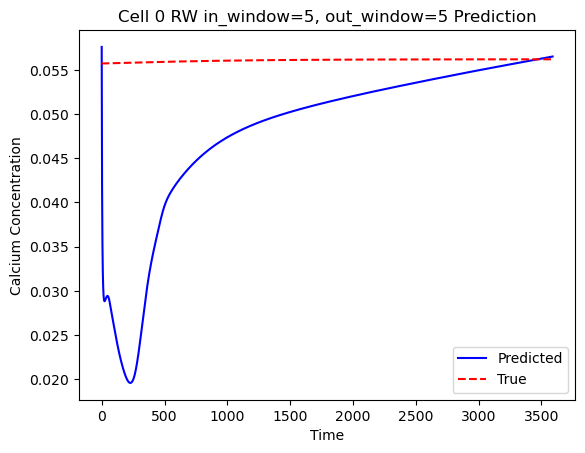

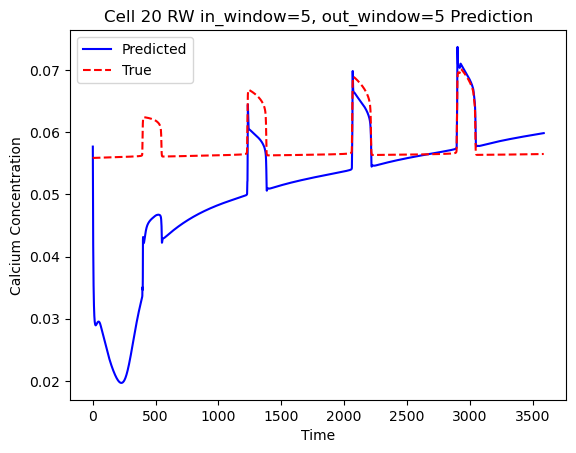

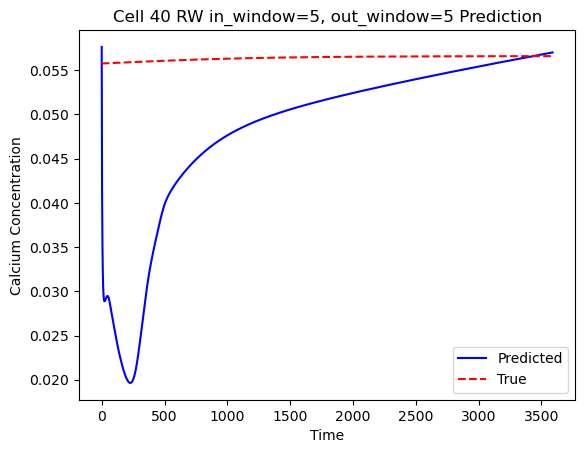

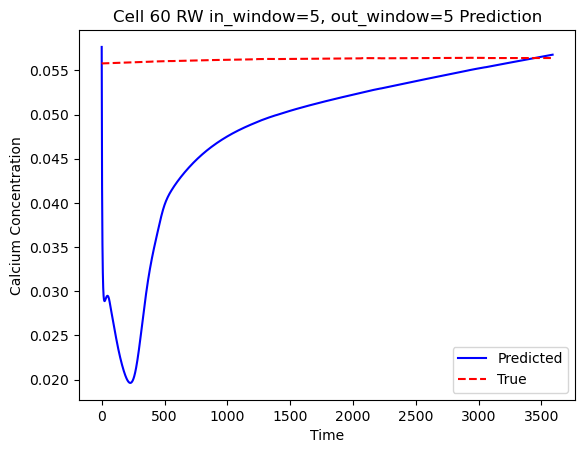

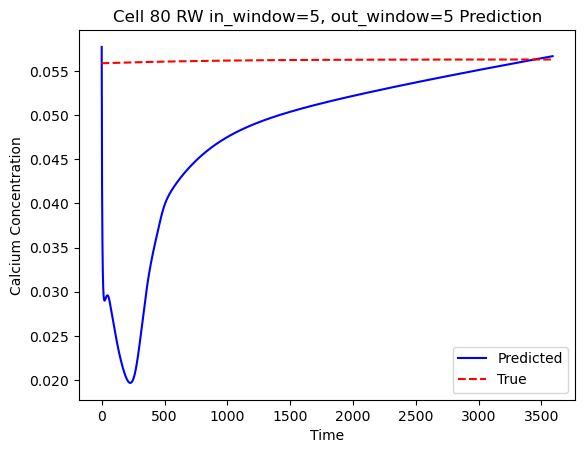

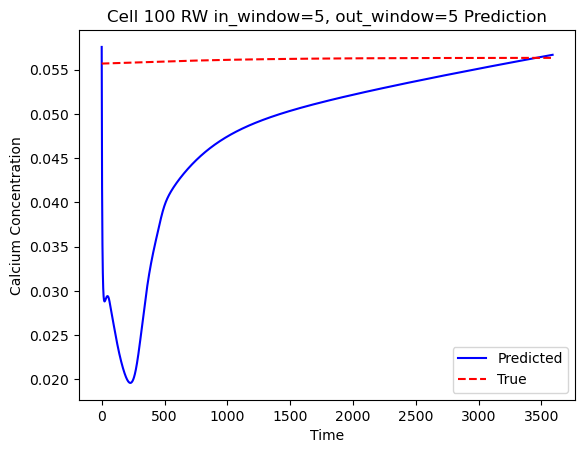

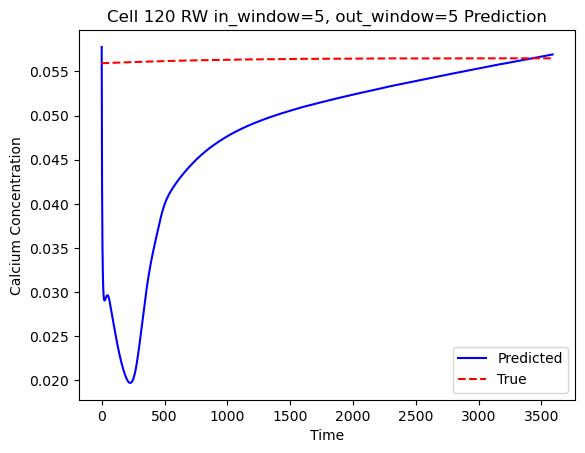

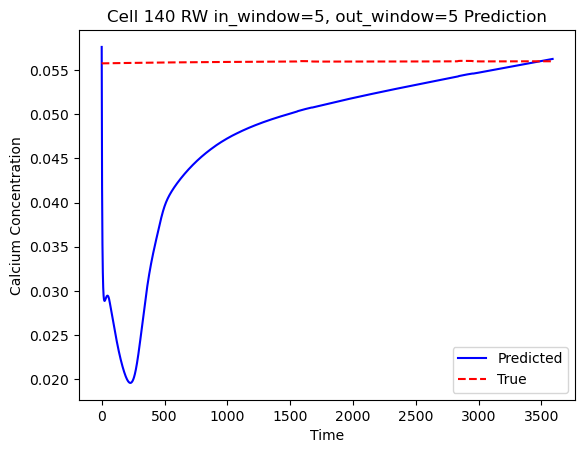

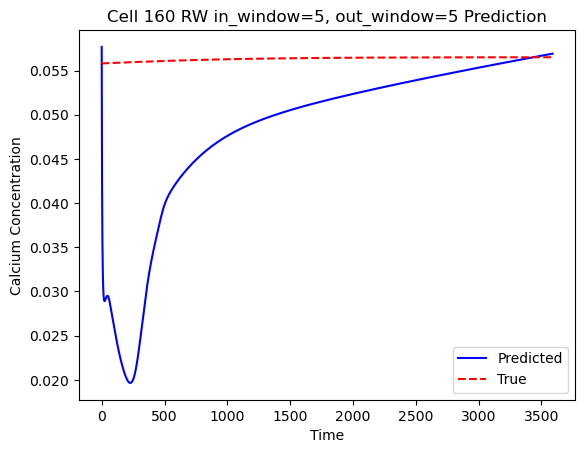

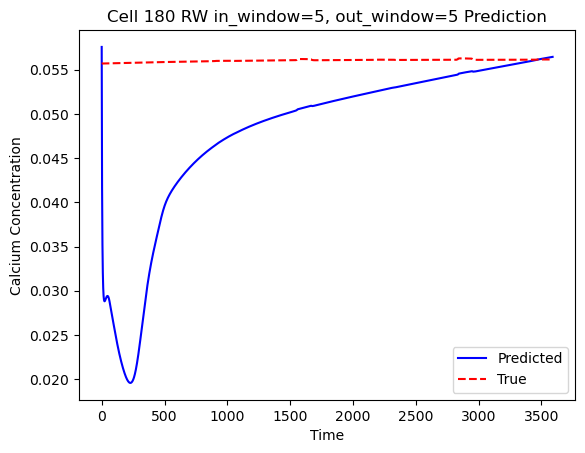

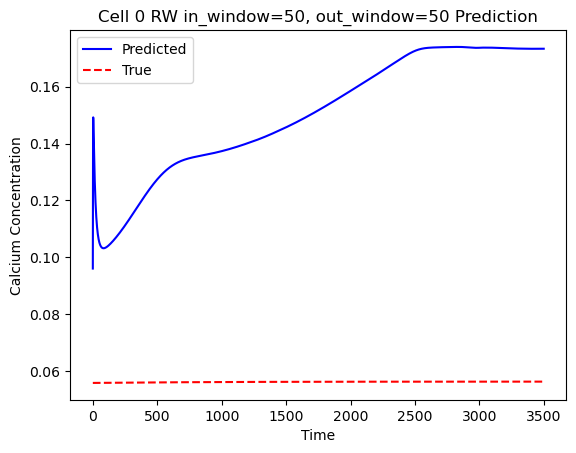

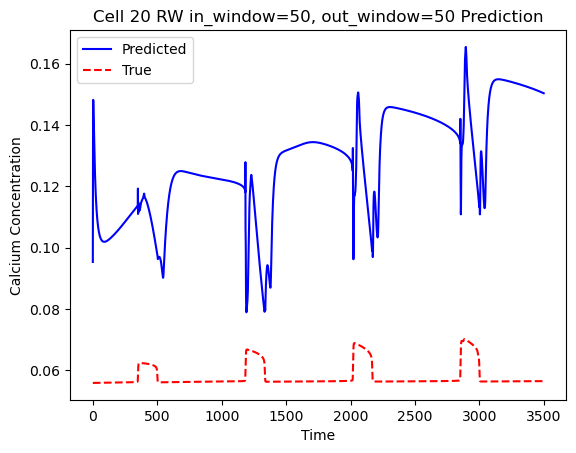

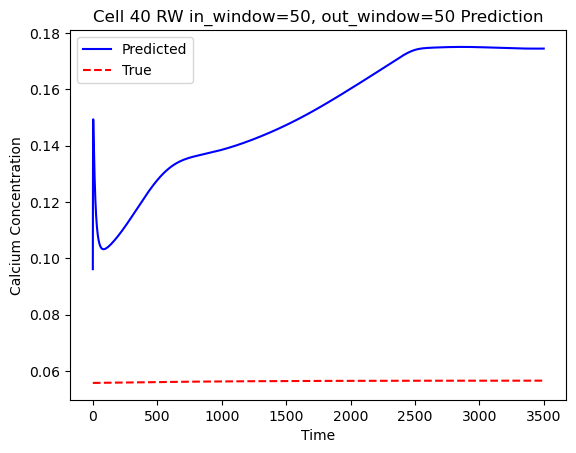

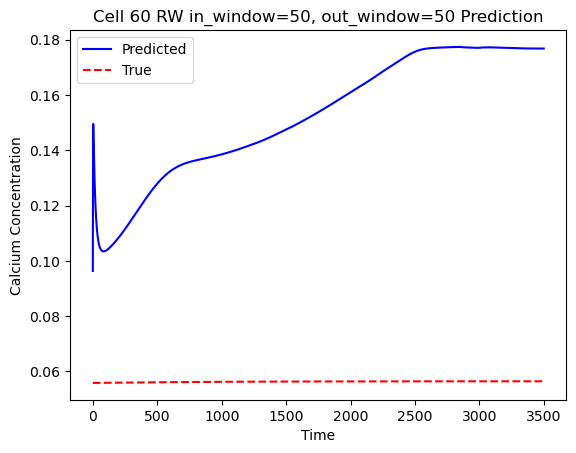

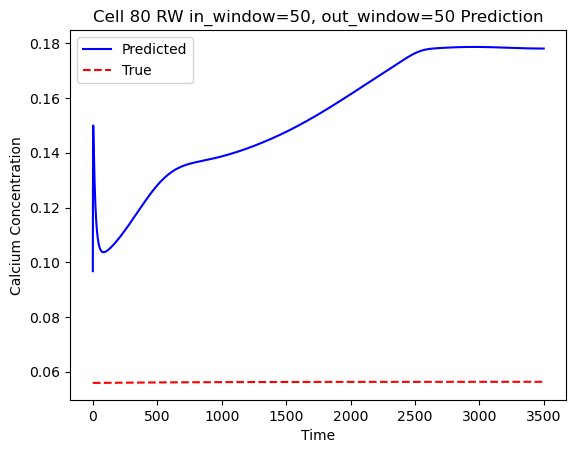

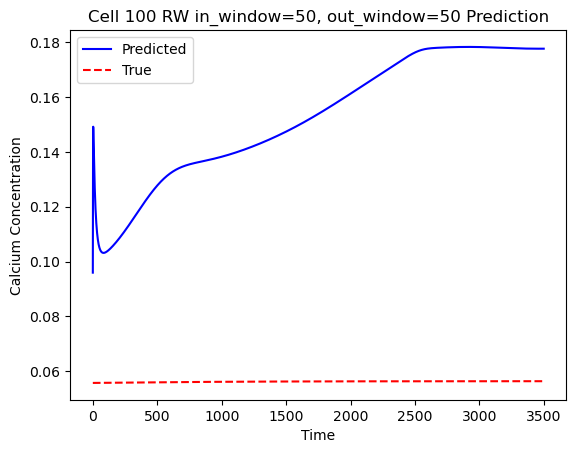

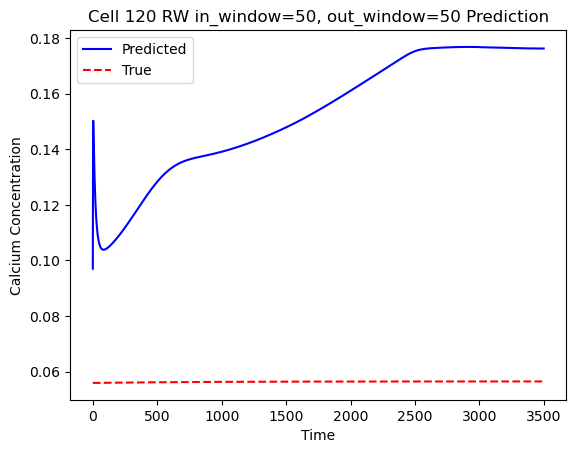

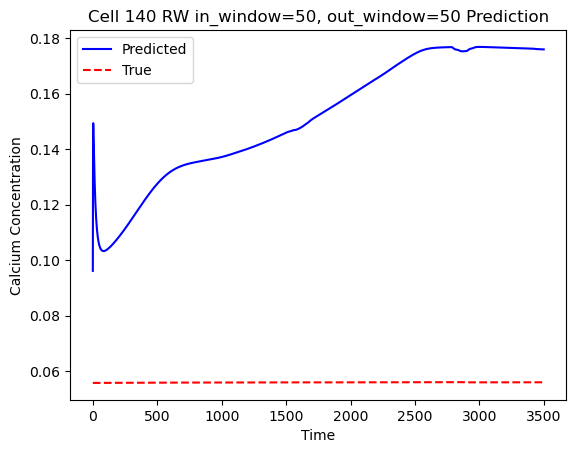

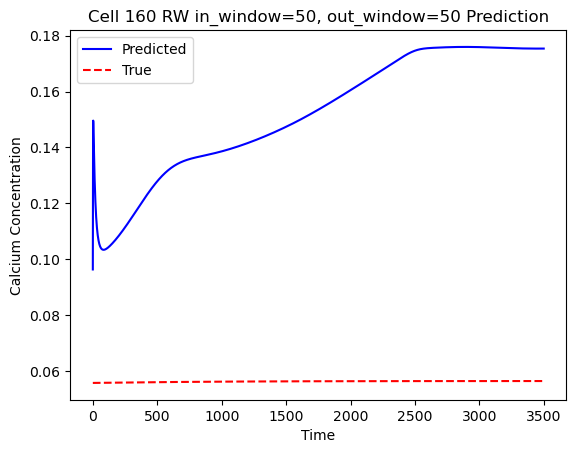

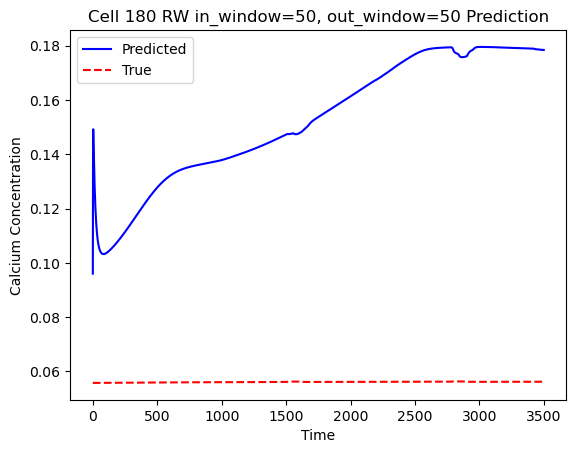

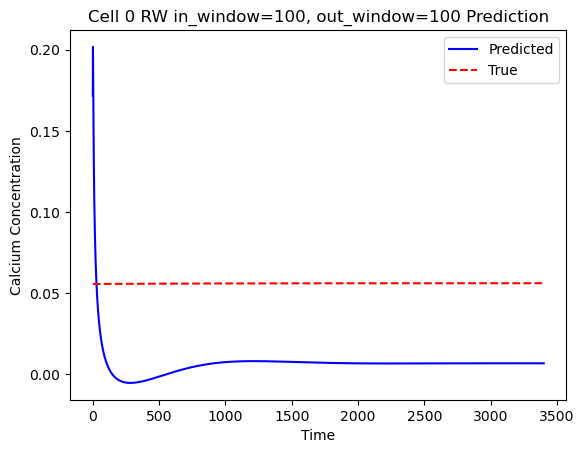

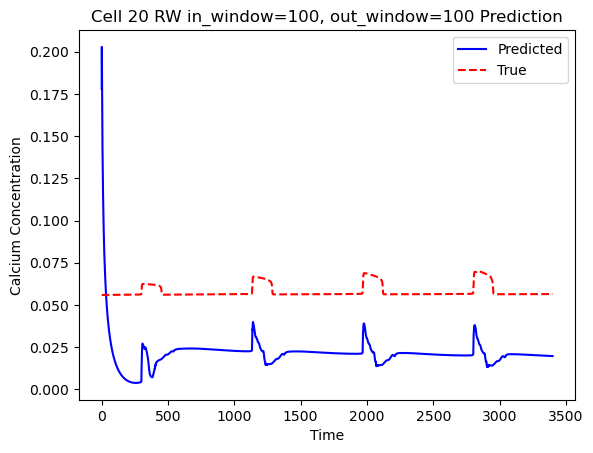

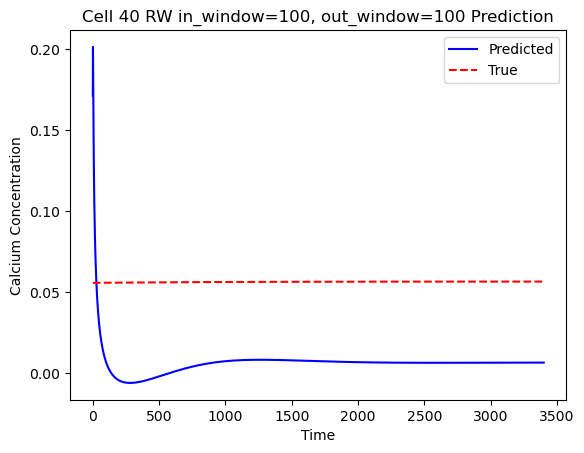

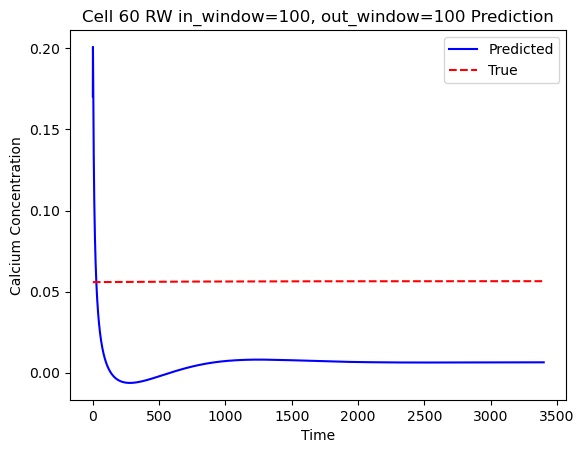

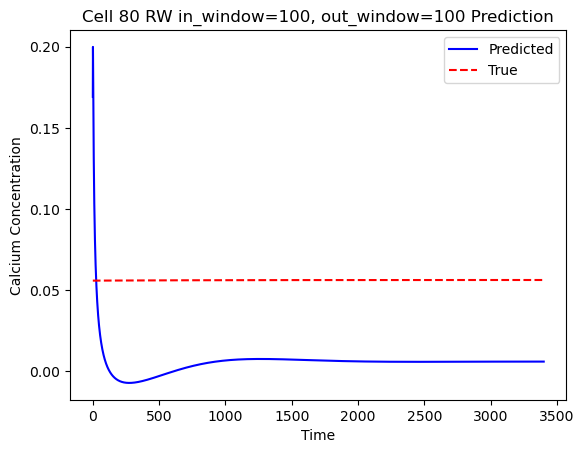

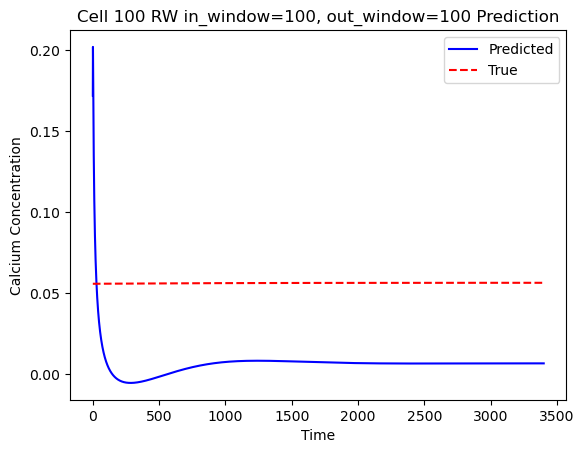

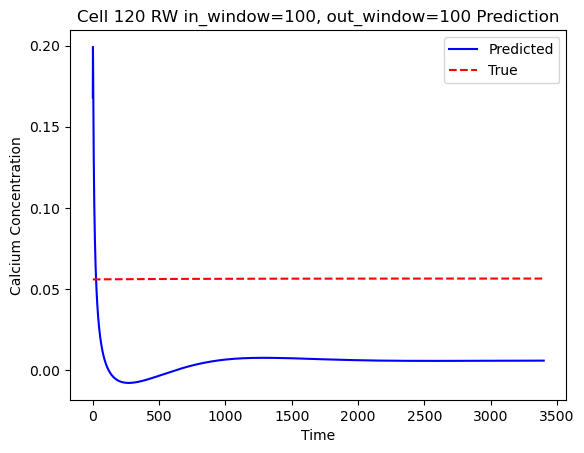

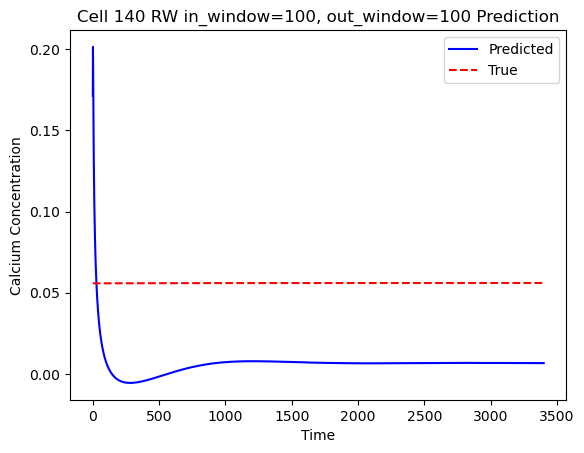

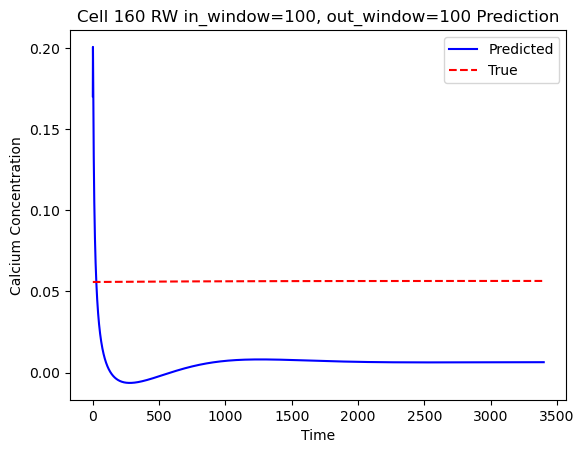

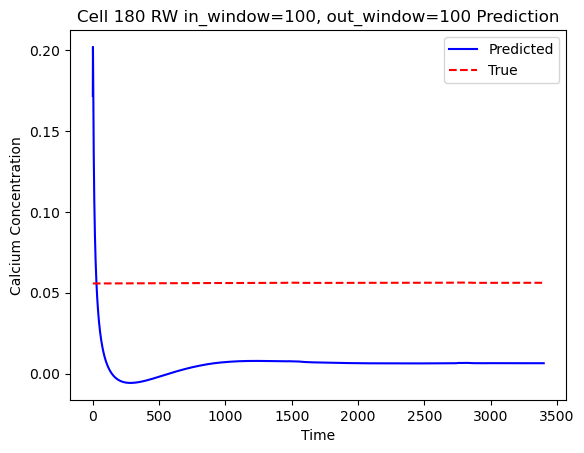

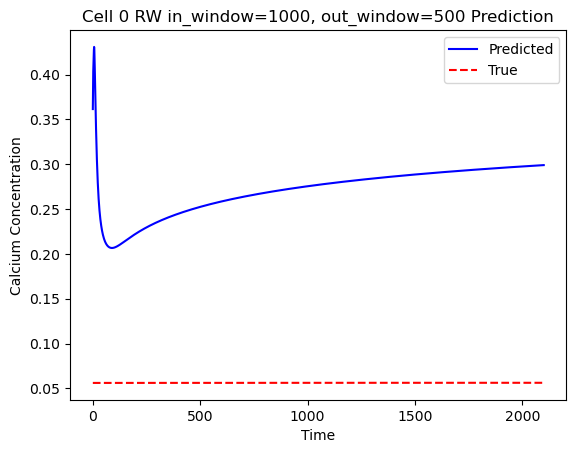

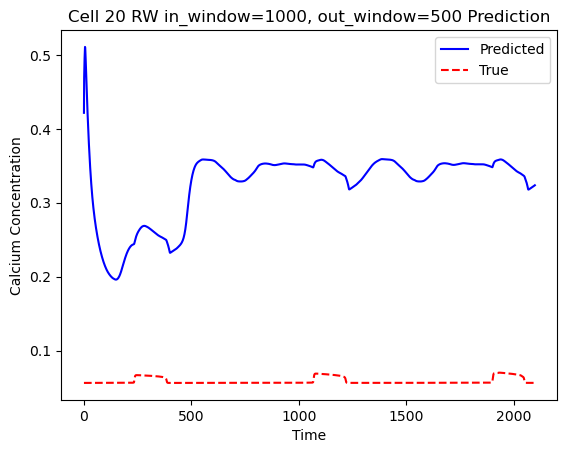

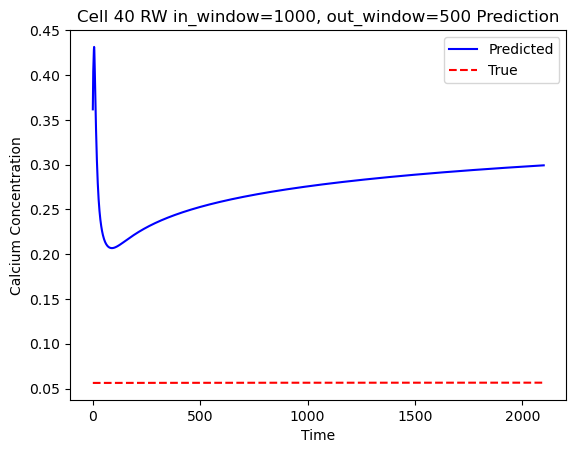

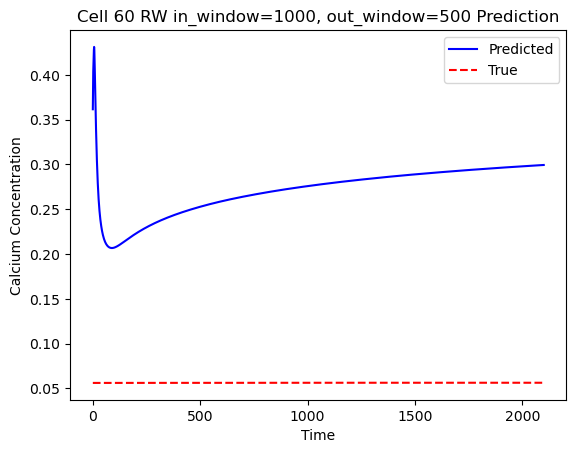

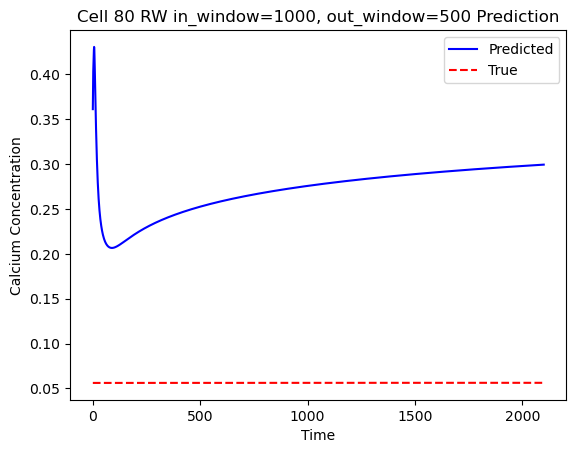

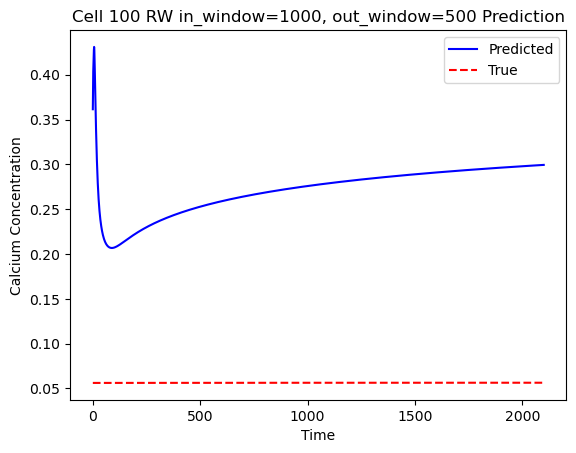

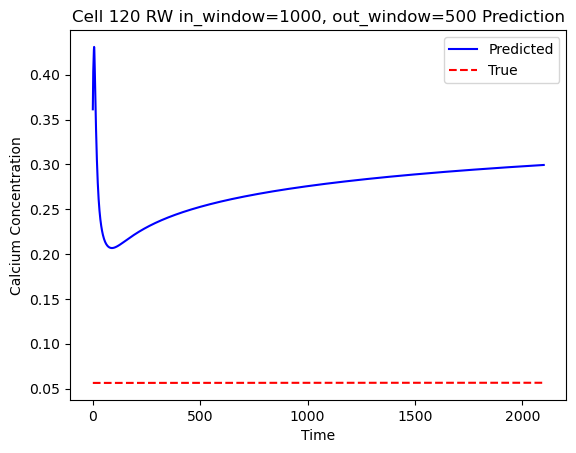

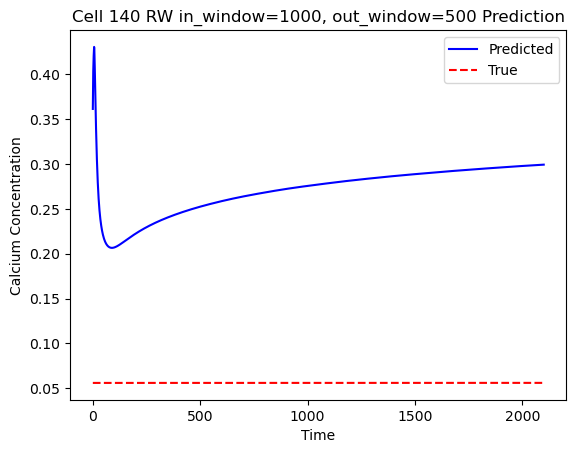

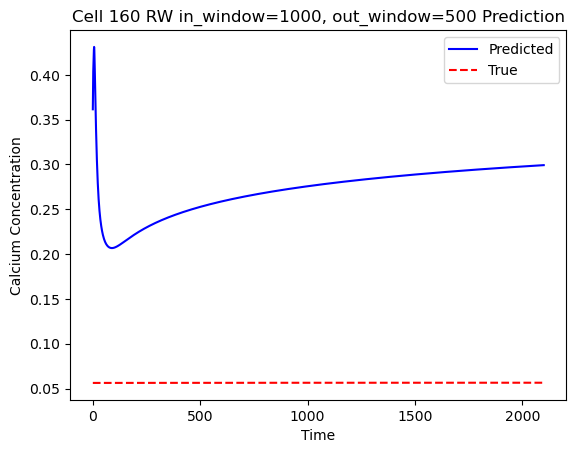

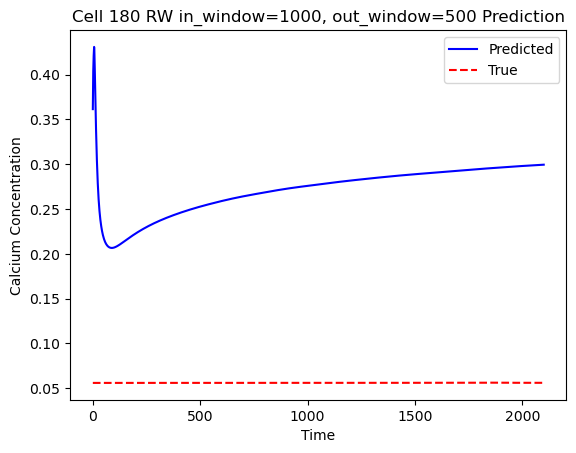

In [140]:
# Plot the preds vs truths for the each trained model
for (in_w, out_w), res in results.items():
    RW_preds_arr_loop = res['preds']
    RW_truths_arr_loop = res['truths']

    cell_indices = testing_set[0].x.shape[0]  # All cell indices
    for i in range(cell_indices):
        if i % 20 != 0:
            continue  # Plot every 10th cell to reduce number of plots

        plt.figure()
        plt.plot(RW_preds_arr_loop[i, :, 0], label='Predicted', color='b')
        plt.plot(RW_truths_arr_loop[i, :, 0], label='True', color='r', linestyle='--')
        plt.title(f'Cell {i} RW in_window={in_w}, out_window={out_w} Prediction')
        plt.xlabel('Time')
        plt.ylabel('Calcium Concentration')
        plt.legend()
        plt.show()

In [141]:
# Save models for later use
for (in_w, out_w), res in results.items():
    model_filename = f'model_RW_{in_w}1{out_w}_12042025.pt'
    torch.save(res['model'], model_filename)
    print(f"Saved model to {model_filename}")


Saved model to model_RW_515_12042025.pt
Saved model to model_RW_50150_12042025.pt
Saved model to model_RW_1001100_12042025.pt
Saved model to model_RW_10001500_12042025.pt


In [154]:
# Get cell data directly from files
folder_path_rf = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_CRC/round2_120225_torch_seed_123567'
files_rf = sorted(os.listdir(folder_path_rf))
print(files_rf)

training_set_rf = torch.load(os.path.join(folder_path_rf, files_rf[1]))
testing_set_rf = torch.load(os.path.join(folder_path_rf, files_rf[-1]))

ICs_file_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_mac/ca_model_dense_initiator_cells_123567.csv'
df_ICs = pd.read_csv(ICs_file_path)
ICs_training = df_ICs['sim_10'].values  # Initiator cells for training set
ICs_testing = df_ICs['sim_9'].values   # Initiator cells for testing set
# Clear NaN values
ICs_training = ICs_training[~np.isnan(ICs_training)].astype(int)
ICs_testing = ICs_testing[~np.isnan(ICs_testing)].astype(int)

print(f"Training set ICs: {ICs_training}")
print(f"Testing set ICs: {ICs_testing}")

['ca_model_dense_base_123567_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim10_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim11_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim12_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim13_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim14_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim15_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim16_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim17_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim18_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim19_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim1_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim20_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim21_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim22_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim23_20251202-180033_PyGT_dataset_111.pt', 'ca_model_dense_sim24_20251202-180

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_60418/3376967662.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_set_rf = torch.load(os.path.join(fol

In [158]:
# Train RF model with sklearn for initiator cell classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
# Prepare data
Ca_data = training_set_rf.Ca.numpy()  # (N, T)
N, T = Ca_data.shape
# Labels: initiator cells (assumed to be known)
initiator_labels_training = np.zeros(N, dtype=int)
initiator_labels_training[ICs_training] = 1

# Build model and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(Ca_data, initiator_labels_training)

# Evaluate on testing set
Ca_data_test = testing_set_rf.Ca.numpy()  # (N, T)
initiator_labels_testing = np.zeros(N, dtype=int)
initiator_labels_testing[ICs_testing] = 1

pred_labels = rf_model.predict(Ca_data_test)
confusion = confusion_matrix(initiator_labels_testing, pred_labels)
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_report(initiator_labels_testing, pred_labels))

# Print predicted initiator cell indices
pred_initiators = np.where(pred_labels == 1)[0]
print(f"Predicted initiator cell indices in testing set: {pred_initiators}")

Confusion Matrix:
[[137  49]
 [  3   6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       186
           1       0.11      0.67      0.19         9

    accuracy                           0.73       195
   macro avg       0.54      0.70      0.51       195
weighted avg       0.94      0.73      0.81       195

Predicted initiator cell indices in testing set: [  0   4  16  18  20  22  23  25  27  30  35  36  39  44  48  49  51  59
  60  64  70  73  74  75  76  79  80  81  82  87  90  93  98 105 106 110
 111 113 114 115 126 131 132 137 146 150 151 163 165 166 168 171 175 176
 187]


In [ ]:
# Flip and use test set to train and vice versa
rf_model_flip = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_flip.fit(Ca_data_test, initiator_labels_testing)
# Evaluate on training set
pred_labels_flip = rf_model_flip.predict(Ca_data)
confusion_flip = confusion_matrix(initiator_labels_training, pred_labels_flip)
print("Confusion Matrix (flipped):")
print(confusion_flip)
print("Classification Report (flipped):")
print(classification_report(initiator_labels_training, pred_labels_flip))

Confusion Matrix (flipped):
[[ 14 177]
 [  4   0]]
Classification Report (flipped):
              precision    recall  f1-score   support

           0       0.78      0.07      0.13       191
           1       0.00      0.00      0.00         4

    accuracy                           0.07       195
   macro avg       0.39      0.04      0.07       195
weighted avg       0.76      0.07      0.13       195

